In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_dropoutcsv.csv')

# 2. Encode categorical data (gender)
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # misalnya: Female=0, Male=1

# 3. Drop missing values
df.dropna(inplace=True)

# 4. Pisahkan fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # Drop kolom grade juga karena berpengaruh
y = df['dropout']

# 5. Train-test split dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Hitung class weights manual (CatBoost tidak support class_weight='balanced')
from collections import Counter
counter = Counter(y_train)
weight_0 = 1
weight_1 = counter[0] / counter[1]  # biasanya 3~6

# 7. Buat pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        class_weights=[weight_0, weight_1],
        eval_metric='F1',
        verbose=0,
        random_state=42
    ))
])

# 8. Train model
pipeline.fit(X_train, y_train)

# 9. Predict & Evaluate
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print("\n=== ROC AUC Score ===")
print(roc_auc_score(y_test, y_proba))

# 10. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print(f"\n=== 5-Fold Cross-Validated F1 Score: {scores.mean():.4f} ===")


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        79
           1       0.14      0.14      0.14        21

    accuracy                           0.63       100
   macro avg       0.45      0.45      0.45       100
weighted avg       0.64      0.63      0.63       100


=== Confusion Matrix ===
[[60 19]
 [18  3]]

=== ROC AUC Score ===
0.41169379144062684

=== 5-Fold Cross-Validated F1 Score: 0.1537 ===


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_dropoutcsv.csv')

# 2. Encode gender
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

# 3. Drop missing values
df = df.dropna()

# 4. Pisahkan fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # Dropout sebagai target, grade dibuang agar fair
y = df['dropout']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. SMOTE untuk oversampling (opsional, bisa juga tanpa)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 7. Pipeline dengan Logistic Regression (balanced)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# 8. Train model
pipeline.fit(X_train_smote, y_train_smote)

# 9. Evaluasi
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("=== ROC AUC Score ===")
print(roc_auc_score(y_test, y_proba))

# 10. Cross-Validation
f1_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print(f"=== 5-Fold Cross-Validated F1 Score: {f1_scores.mean():.4f} ===")


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.62      0.68        79
           1       0.14      0.24      0.18        21

    accuracy                           0.54       100
   macro avg       0.45      0.43      0.43       100
weighted avg       0.63      0.54      0.58       100

=== Confusion Matrix ===
[[49 30]
 [16  5]]
=== ROC AUC Score ===
0.4677516576250753
=== 5-Fold Cross-Validated F1 Score: 0.2629 ===


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # Buang target dan grade
y = df['dropout']

# 2. Kolom kategorik dan numerik
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 3. Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 4. Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

# 5. Split dan training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

# 6. Evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87        79
           1       0.50      0.29      0.36        21

    accuracy                           0.79       100
   macro avg       0.66      0.60      0.62       100
weighted avg       0.76      0.79      0.77       100

Confusion Matrix:
 [[73  6]
 [15  6]]
Cross-Validation Accuracy (5-fold): 0.64


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Dataset
# Asumsikan df sudah ada dan bersih
X = df.drop(columns=['grade', 'dropout'])  # Buang target dan label lama
y = df['grade']  # Target: grade

# 2. Fitur numerik & kategorikal
categorical_features = ['gender', 'activity_type']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 3. Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 4. XGBoost Regression pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ))
])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6. Fit model
pipeline.fit(X_train, y_train)

# 7. Predict
y_pred = pipeline.predict(X_test)

# 8. Evaluation
print("=== Regression Metrics ===")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")

# 9. Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(f"5-Fold Cross-Validated R² Score: {cv_scores.mean():.4f}")


ValueError: A given column is not a column of the dataframe

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd 

df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/DROPOUT FINAL.csv')

# 1. Fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # Buang target dan grade
y = df['dropout']

# 2. Kolom kategorik dan numerik
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 3. Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 4. Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

# 5. Split dan training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

# 6. Evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76        69
           1       0.47      0.48      0.48        31

    accuracy                           0.67       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.67      0.67      0.67       100

Confusion Matrix:
 [[52 17]
 [16 15]]
Cross-Validation Accuracy (5-fold): 0.50


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd 

df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/DATASET DROPOUT 4.csv')

# 1. Fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # Buang target dan grade
y = df['dropout']

# 2. Kolom kategorik dan numerik
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 3. Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 4. Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

# 5. Split dan training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

# 6. Evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        59
           1       0.73      0.54      0.62        41

    accuracy                           0.73       100
   macro avg       0.73      0.70      0.71       100
weighted avg       0.73      0.73      0.72       100

Confusion Matrix:
 [[51  8]
 [19 22]]
Cross-Validation Accuracy (5-fold): 0.55


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# 1. Load data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/DATASET DROPOUT 4.csv')

# 2. Fitur dan target
X = df.drop(columns=['dropout','grade'])
y = df['dropout']

# 3. Kolom kategorikal dan numerikal
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Pipeline model
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# 6. Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7. Fit model
pipeline.fit(X_train, y_train)

# 8. Predict dan evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f}")

# # 10. Simpan model
# joblib.dump(pipeline, 'xgboost_dropout_model.pkl')
# print("Model berhasil disimpan sebagai 'xgboost_dropout_model.pkl'")


d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.86      0.79        59
           1       0.73      0.54      0.62        41

    accuracy                           0.73       100
   macro avg       0.73      0.70      0.71       100
weighted avg       0.73      0.73      0.72       100

Confusion Matrix:
 [[51  8]
 [19 22]]


d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:18

Cross-Validation Accuracy (5-fold): 0.5540


In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# 1. Load data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')

# 2. Fitur dan target
X = df.drop(columns=['dropout', 'grade'])
y = df['dropout']

# 3. Kolom kategorikal dan numerikal
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Hitung scale_pos_weight untuk kelas imbalanced
jumlah_kelas_0 = (y == 0).sum()
jumlah_kelas_1 = (y == 1).sum()
scale = jumlah_kelas_0 / jumlah_kelas_1

# 6. Pipeline model dengan XGBClassifier dan scale_pos_weight
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale
    ))
])

# 7. Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 8. Fit model
pipeline.fit(X_train, y_train)

# 9. Predict dan evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 10. Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f}")

# 11. Simpan model
# joblib.dump(pipeline, 'xgboost_dropout_model.pkl')
# print("Model berhasil disimpan sebagai 'xgboost_dropout_model.pkl'")


d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:08:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77        59
           1       0.66      0.80      0.73        41

    accuracy                           0.75       100
   macro avg       0.75      0.76      0.75       100
weighted avg       0.77      0.75      0.75       100

Confusion Matrix:
 [[42 17]
 [ 8 33]]


d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:08:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:08:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:08:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:18

Cross-Validation Accuracy (5-fold): 0.5380


d:\1.UNI 5th Semester\6. Advance DataBase\ADVANCE_DB PROJECT\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:08:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# 1. Load data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')

# 2. Fitur dan target
X = df.drop(columns=['dropout', 'grade'])
y = df['dropout']

# 3. Kolom kategorikal dan numerikal
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Pipeline model dengan RandomForestClassifier
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
    ))
])

# 6. Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Fit model
pipeline.fit(X_train, y_train)

# 8. Predict dan evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f}")

# # 10. Simpan model
# joblib.dump(pipeline, 'randomforest_dropout_model.pkl')
# print("Model berhasil disimpan sebagai 'randomforest_dropout_model.pkl'")


Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80        59
           1       0.84      0.39      0.53        41

    accuracy                           0.72       100
   macro avg       0.77      0.67      0.67       100
weighted avg       0.75      0.72      0.69       100

Confusion Matrix:
 [[56  3]
 [25 16]]
Cross-Validation Accuracy (5-fold): 0.6460


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
import joblib

# 1. Load data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')

# 2. Drop kolom target
X = df.drop(columns=['dropout', 'grade'])

# 3. Pisahkan fitur kategori dan numerik
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Buat preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Buat pipeline dengan IsolationForest
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', IsolationForest(contamination=0.1, random_state=42))
])

# 6. Fit model
pipeline.fit(X)

# 7. Prediksi
df['anomaly'] = pipeline.predict(X)  # -1 = anomali, 1 = normal

# # 8. Simpan model dan hasil
# model_path = '/mnt/data/isolation_forest_model.pkl'
# result_path = '/mnt/data/anomaly_detection_results.csv'

# joblib.dump(pipeline, model_path)
# df.to_csv(result_path, index=False)

# print("Model dan hasil prediksi disimpan.")


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import joblib

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')

# 2. Drop kolom target dari fitur input
X = df.drop(columns=['dropout', 'grade'])  # gunakan grade hanya jika perlu prediksi regresi nanti
y_true = df['dropout']  # label ground truth untuk evaluasi

# 3. Definisikan fitur kategorikal dan numerikal
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Pipeline IsolationForest
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', IsolationForest(contamination=0.1, random_state=42))
])

# 6. Fit model
pipeline.fit(X)

# 7. Predict anomaly (-1 = anomali, 1 = normal)
anomaly_pred = pipeline.predict(X)

# 8. Ubah -1 jadi 1 (dropout), 1 jadi 0 (aktif) agar bisa dibandingkan dengan y_true
y_pred = pd.Series(anomaly_pred).apply(lambda x: 1 if x == -1 else 0)

# 9. Simpan prediksi ke dataframe
df['anomaly'] = y_pred

# 10. Evaluasi jika label dropout tersedia
print("=== Evaluation with Ground Truth (dropout) ===\n")
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred):.4f}")

# # 11. Simpan model & hasil (opsional)
# joblib.dump(pipeline, 'isolation_forest_model.pkl')
# df.to_csv('anomaly_detection_results.csv', index=False)
# print("\nModel & hasil disimpan sebagai 'isolation_forest_model.pkl' dan 'anomaly_detection_results.csv'")


=== Evaluation with Ground Truth (dropout) ===

Confusion Matrix:
[[291   4]
 [159  46]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       295
           1       0.92      0.22      0.36       205

    accuracy                           0.67       500
   macro avg       0.78      0.61      0.57       500
weighted avg       0.76      0.67      0.61       500

Accuracy: 0.6740
F1 Score: 0.3608
ROC AUC Score: 0.6054


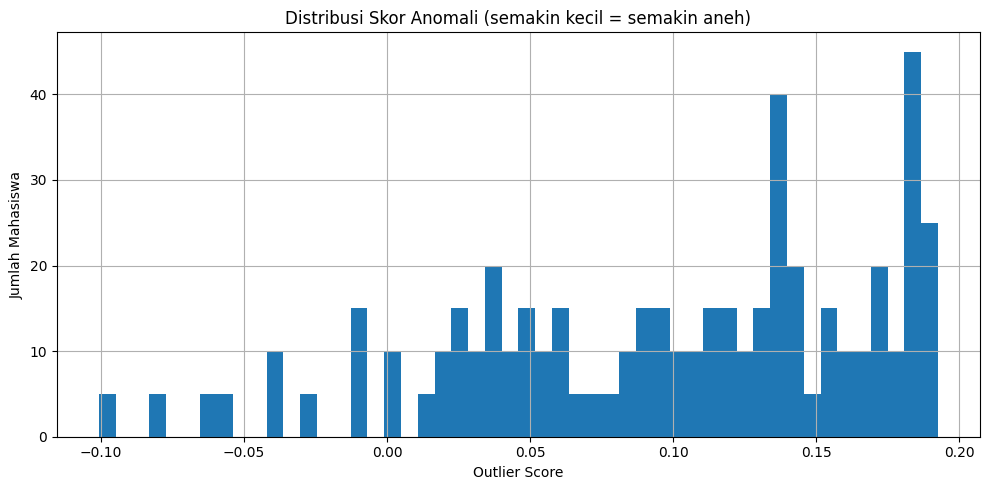

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')

# 2. Drop kolom target dari fitur input
X = df.drop(columns=['dropout', 'grade'])

# 3. Definisikan fitur kategorikal dan numerikal
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Pipeline IsolationForest
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', IsolationForest(contamination=0.1, random_state=42))
])

# 6. Fit model
pipeline.fit(X)

# 7. Dapatkan skor anomali
scores = pipeline.named_steps['model'].decision_function(
    pipeline.named_steps['preprocess'].transform(X)
)

# 8. Visualisasi distribusi skor
plt.figure(figsize=(10, 5))
plt.hist(scores, bins=50)
plt.title("Distribusi Skor Anomali (semakin kecil = semakin aneh)")
plt.xlabel("Outlier Score")
plt.ylabel("Jumlah Mahasiswa")
plt.grid(True)
plt.tight_layout()
plt.show()


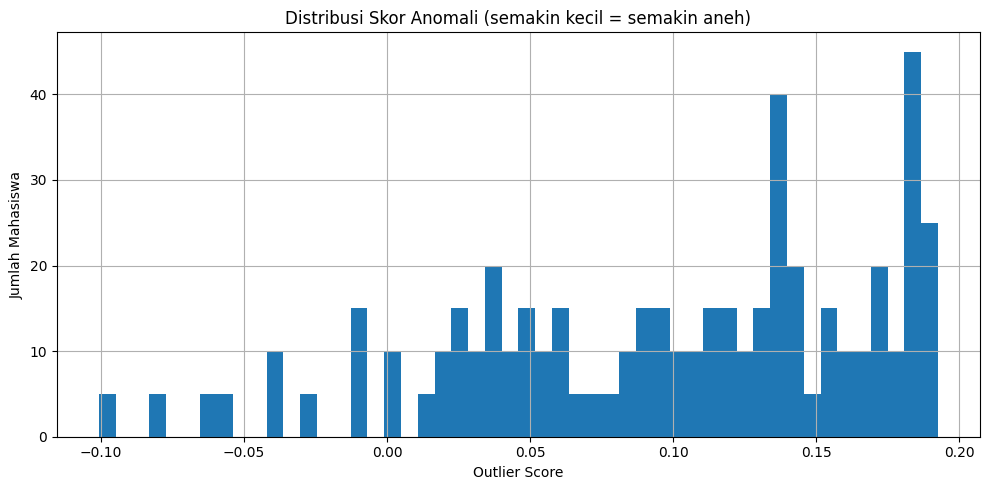

✅ Model berhasil disimpan ke: D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/anomaly/isolation_forest_model.pkl


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import joblib  # Untuk menyimpan model

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')

# 2. Drop kolom target dari fitur input
X = df.drop(columns=['dropout', 'grade'])

# 3. Definisikan fitur kategorikal dan numerikal
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Pipeline IsolationForest
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', IsolationForest(contamination=0.1, random_state=42))
])

# 6. Fit model
pipeline.fit(X)

# 7. Dapatkan skor anomali
scores = pipeline.named_steps['model'].decision_function(
    pipeline.named_steps['preprocess'].transform(X)
)

# 8. Visualisasi distribusi skor
plt.figure(figsize=(10, 5))
plt.hist(scores, bins=50)
plt.title("Distribusi Skor Anomali (semakin kecil = semakin aneh)")
plt.xlabel("Outlier Score")
plt.ylabel("Jumlah Mahasiswa")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Simpan model ke .pkl
model_path = 'D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/anomaly/isolation_forest_model.pkl'
joblib.dump(pipeline, model_path)
print(f"✅ Model berhasil disimpan ke: {model_path}")


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# 1. Load data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')

# 2. Fitur dan target
X = df.drop(columns=['dropout', 'grade'])
y = df['dropout']

# 3. Kolom kategorikal dan numerikal
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 4. Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 5. Pipeline model dengan RandomForestClassifier
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        random_state=42
    ))
])

# 6. Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Fit model
pipeline.fit(X_train, y_train)

# 8. Predict dan evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {cv_scores.mean():.4f}")

# 10. Simpan model
model_path = 'D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/randomforest_dropout_model.pkl'
joblib.dump(pipeline, model_path)
print(f"✅ Model berhasil disimpan ke: {model_path}")




Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80        59
           1       0.84      0.39      0.53        41

    accuracy                           0.72       100
   macro avg       0.77      0.67      0.67       100
weighted avg       0.75      0.72      0.69       100

Confusion Matrix:
 [[56  3]
 [25 16]]
Cross-Validation Accuracy (5-fold): 0.6460
✅ Model berhasil disimpan ke: D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/randomforest_dropout_model.pkl


In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import joblib

# Load data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout/DATASET DROPOUT 4.csv')
X = df.drop(columns=['dropout', 'grade'])

categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# Pipeline + KMeans
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit model
pipeline.fit(X)

# Get cluster labels
X_transformed = pipeline.named_steps['preprocess'].transform(X)
cluster_labels = pipeline.named_steps['kmeans'].labels_

# Evaluasi
inertia = pipeline.named_steps['kmeans'].inertia_
silhouette = silhouette_score(X_transformed, cluster_labels)
db_score = davies_bouldin_score(X_transformed, cluster_labels)

print("\n🔍 Evaluasi Clustering:")
print(f"- Inertia (jumlah kuadrat jarak dalam cluster): {inertia:.2f}")
print(f"- Silhouette Score (semakin dekat ke 1 lebih baik): {silhouette:.3f}")
print(f"- Davies-Bouldin Score (semakin kecil lebih baik): {db_score:.3f}")

# Save model
model_path = 'D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/clustering/kmeans_anomaly_model.pkl'
joblib.dump(pipeline, model_path)
print(f"\n✅ Model clustering disimpan di {model_path}")



🔍 Evaluasi Clustering:
- Inertia (jumlah kuadrat jarak dalam cluster): 514.95
- Silhouette Score (semakin dekat ke 1 lebih baik): 0.417
- Davies-Bouldin Score (semakin kecil lebih baik): 0.853

✅ Model clustering disimpan di D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/clustering/kmeans_anomaly_model.pkl
